Linearly seperable EcoSVM code,

Owen Howell, July 15, 2019
olh20@bu.edu, https://owenhowell20.github.io


This code runs EcoSVDM algoritm and compares with batch SVM
It produces Figure 4 in the paper

In [1]:

#Import standard python packages
import numpy as np 	
import matplotlib.pyplot as plt
import sys

#QP is done with CVXOPT packages
from cvxopt import matrix, solvers
import numpy as np
solvers.options['show_progress'] = False 


#A global error threshold, any small number can be used
thresh = 1e-3

In [2]:

#Function to generate the training data. Any linearly seperable dataset can be used.
#Returns dataset and dateset labels
def train_data(N, dimension):
	
	#Draw set of random points
	xvals = np.random.uniform(0,1,[N,dimension])
	yvals = np.ones([N])

	
	for i in range(N):

		#Linearly Seperable
		if (xvals[i,0]>0.5):

			yvals[i] = -1



	return xvals, yvals


In [3]:

#Function to generate the test data. Any linearly seperable dataset can be used.
#Returns dataset and dateset labels
def test_data(N_test, dimension):
	
	#Draw set of random points
	xvals = np.random.uniform(0,1,[N_test,dimension])
	yvals = np.ones([N_test])

	
	for i in range(N_test):
	
		#Linearly Seperable
		if (xvals[i,0]>0.5):

			yvals[i] = -1


	return xvals, yvals

In [4]:

#Defining a linear kernel function
def kernel(x,y):

	return np.dot(x,np.transpose(y))

In [5]:


#Intilize the EcoSVM, compute support vectors for first N_start points
#Inputs are the datapoints, data labels
#Returns the set of active datapoints, active datapoint labels, support vector values
def EcoSVM_initialize(xvals,yvals):

	N_start = len(yvals)
 
	#Function to generate the intial kernel matrix
	def intial_kernel_matrix():

		#Compute the intial kernel matrix
		Qmat = np.zeros([N_start,N_start])

		for i in range(N_start):
			for j in range(N_start):

				#using a linear kernel
				s =  kernel(xvals[i],xvals[j])

				Qmat[i,j] = s*yvals[i]*yvals[j]

		return Qmat

	Qmat = intial_kernel_matrix()

	#Convert to CVXOPT format
	Q = matrix(Qmat)

	p = - np.ones(N_start)
	p = matrix(p)

	G = np.zeros([N_start,N_start])
	for i in range(N_start):
		G[i,i] = -1

	G = matrix(G)

	h = np.zeros([N_start])
	h = matrix(h)

	A = np.zeros(N_start)
	for i in range(N_start):
		A[i] = yvals[i]

	A = matrix(A,(1,N_start),'d')

	b = matrix(0.0)

	sol =  solvers.qp(Q, p, G, h, A, b)

	#the intial values of solution
	#KKT values a_{i}
	KKT = np.array( sol['x'] )


	#only care about non-zero values
	for i in range(N_start):
		if (KKT[i] < thresh) :
			KKT[i] = 0

	#Only need to keep non-zero KKT values, also know as support vectors
	#Find intial support vector values and support vector indices
	support_vects_inds = np.array( np.ndarray.nonzero(KKT)[0] )
	support_vects = KKT[support_vects_inds]

	#the set of active datapoints
	active_data_x = intial_xvals[support_vects_inds,:]
	active_data_y = intial_yvals[support_vects_inds]

	#Check that there is at least one active support vector

	if (   len(support_vects_inds) == 0 ):

		print("Not enough intial points, no active support vector found. Make sure that there are both +1 and -1 examples.")
		quit()


	return active_data_x, active_data_y, support_vects

In [6]:


#Run the EcoSVM algorithm on a single new point
#Inputs are datapoint X, datalabel Y, active datapoints, active data labels, set of support vectors and the dataset dimension
#Returns the new set of data points and labels, the new set of support vectors
def point_Run_EcoSVM( X, Y , active_data_x , active_data_y , support_vects , dimension  ):


	numsupportvects = len(active_data_y)

	s = 0


	for i in range(numsupportvects):

		Qval = Y*active_data_y[i]*(  kernel( X , active_data_x[i,:]  )  - kernel( active_data_x[0,:], active_data_x[i,:]  ) )

		s = s + Qval*support_vects[i]
	

	#Compute the invasion condition
	inv = 1 - Y * active_data_y[0] - s

	if (inv>=0):

		#The new species can invade. Recompute the steady state using QP

		Qp = np.zeros([numsupportvects+1,numsupportvects+1])


		for i in range(numsupportvects):
			for j in range(numsupportvects):

					s = kernel(active_data_x[i,:],active_data_x[j,:])

					Qp[i,j] = s*active_data_y[i]*active_data_y[j]

		for i in range(numsupportvects):

			s = kernel(active_data_x[i,:], X)

			Qp[i,numsupportvects] = s*active_data_y[i]*Y

			Qp[numsupportvects,i] = s*active_data_y[i]*Y
		

		s = kernel(X,X)
	
		Qp[numsupportvects,numsupportvects] = s*Y * Y

		Qp = matrix(Qp)

		p = - np.ones(numsupportvects+1)
		p = matrix(p)


		G = np.zeros([numsupportvects+1,numsupportvects+1])
		for i in range(numsupportvects+1):
			G[i,i] = -1
		G = matrix(G)


		h = np.zeros([numsupportvects+1])
		h = matrix(h)


		A = np.zeros(numsupportvects+1)
		for i in range(numsupportvects):
			A[i] = active_data_y[i]

		A[numsupportvects] = Y
		A = matrix(A,(1,numsupportvects+1),'d')

		b = matrix(0.0)

		#Call QP function
		sol =  solvers.qp(Qp, p, G, h, A, b)

		#QP solution as array, all KKT values
		KKT = np.array( sol['x'] )

		#Get the new support vector indices and values
		#only care about non-zero support vectors
		countnew = 0
		for i in range(len(KKT)):
			if (KKT[i] < thresh):
				KKT[i] = 0
				countnew = countnew + 1

		countnew = len(KKT) -  countnew
		

		# #set up some indices to check
		# indexarray = np.zeros([numsupportvects+1])
		# for i in range(numsupportvects):
		# 	indexarray[i] = support_vects_inds[i]

		# indexarray[numsupportvects] = point

		#the set of new support vectors and support vector indices
		new_active_data_x = np.zeros([countnew, dimension])
		new_active_data_y = np.zeros([countnew])
		newsuppvects = np.zeros([countnew])


		auxcount = 0
		auxcount2 = 0
		for i in range(len(KKT)-1):

			if (KKT[i] > thresh):
				new_active_data_x[auxcount,:] = active_data_x[auxcount2,:]
				new_active_data_y[auxcount] = active_data_y[auxcount2]

		
				newsuppvects[auxcount] = KKT[i]
				auxcount = auxcount + 1
				auxcount2 = auxcount2 + 1

			if (KKT[i]<thresh):
				auxcount2 = auxcount2 + 1



		if (KKT[len(KKT)-1]>thresh):


			new_active_data_x[auxcount,:] = X
			new_active_data_y[auxcount] = Y



			newsuppvects[auxcount] = KKT[len(KKT)-1]
			auxcount = auxcount + 1

	
		
		#New support vector values and indices
		support_vects = newsuppvects

		active_data_y = new_active_data_y

		#zero array because it can change shape
		active_data_x = np.zeros( [len(support_vects) , dimension ] )
		active_data_x = new_active_data_x

	
	return active_data_x, active_data_y, support_vects


In [7]:

#Run the EcoSVM algorithm
#Inputs are datapoints and labels, set of intial support vector indices, intial support vector values
#Returns the set of active datapoints, the active data labels, the support vector values the accuracy and number of support vectors over time
def Run_EcoSVM( xvals, yvals, active_data_x, active_data_y, support_vects ):

	test_accuracy = np.zeros([ N - N_start])
	number_active = np.zeros([ N - N_start])

	#the dataset dimension
	dimension = len(xvals[0,:])

	#Run the EcoSVM algorithm over all points
	for point in range(N_start,N):

		#compute the b value
		b = b_value(active_data_x,active_data_y,support_vects)

		#Compute performance errors
		EcoSVMerror = SVM_error(test_xvals,test_yvals, active_data_x, active_data_y, support_vects,b)

		test_accuracy[point - N_start] = 1 - EcoSVMerror
		number_active[ point - N_start ] = len( active_data_y )

		X = xvals[point,:]
		Y = yvals[point]

		#Run the EcoSVM algorithm on a single point
		active_data_x, active_data_y, support_vects = point_Run_EcoSVM( X , Y , active_data_x, active_data_y , support_vects , dimension )

	

	
	return active_data_x, active_data_y , support_vects , test_accuracy , number_active


In [8]:

#Run a batch SVM on all data
#input is all training data and training labels
#output is the set of active datapoints and data labels and support vector values
def batchSVM( xvals , yvals ):

	#the number of datapoints
	N = len(yvals)

	#the full kernel matrix for batch SVM
	Qfull = np.zeros([N,N])

	for i in range(N):
		for j in range(N):

			#using a linear kernel
			s =  kernel(xvals[i],xvals[j])

			Qfull[i,j] = s*yvals[i]*yvals[j]

	#The full batch SVM solution with QP	
	#Convert into CVXOPT format

	Qf = matrix(Qfull)

	pf = - np.ones(N)
	pf = matrix(pf)


	Gf = np.zeros([N,N])
	for i in range(N):
		Gf[i,i] = -1

	Gf = matrix(Gf)

	hf = np.zeros([N])
	hf = matrix(hf)

	Af = np.zeros(N)
	for i in range(N):
		Af[i] = yvals[i]

	Af = matrix(Af,(1,N),'d')

	bf = matrix(0.0)

	sol =  solvers.qp(Qf, pf, Gf, hf, Af, bf)

	evars = np.array( sol['x'] )


	#only care about non-zero support vectors
	for i in range(N):
		if (evars[i] < thresh):
			evars[i] = 0


	#Find support vectors and support vector indices for Batch SVM
	supvectsindsfull = np.array( np.ndarray.nonzero(evars)[0] )
	supvectsfull = evars[supvectsindsfull]

	active_data_x = xvals[ supvectsindsfull ,:]
	active_data_y = yvals[supvectsindsfull ]

	return active_data_x, active_data_y, supvectsfull


In [9]:

#Compute the b value for an SVM
#Inputs are set of active datapoints and data labels and support vector values
def b_value(active_data_x,active_data_y,supportvectors):

	b = 0
	#Compute the b value
	s = 0 
	for i in range(len(supportvectors)):

		s = s + active_data_y[i]

		for j in range(len(supportvectors)):

			s = s - supportvectors[j] * active_data_y[j] * kernel( active_data_x[i,:] , active_data_x[j,:]     )


	size = float( len(supportvectors) )
	if (size!=0):
		b = 1/size * s

	if (size==0):
		print("ERROR")

	return b



In [10]:

#the SVM prediction function
#Inputs are datapoint x to make prediction on, set of indices, set of support vectors and b value
#Output is the prediction value +1 or -1
def pred(x , active_data_x, active_data_y , supportvectors , b):
	
	s = 0

	for i in range(len(supportvectors)):

		s = s + active_data_y[i] * supportvectors[i] * kernel(x , active_data_x[i,:]  )

	s = s + b


	return s


In [11]:

#Function to compute test error
#Inputs are testing data and labels, set of support vector indices and support vector values
#Returns test error
def SVM_error( test_xvals , test_yvals , active_data_x, active_data_y , support_vects,b):

	#the number of test points
	N_test = len( test_yvals )

	#Compute the EcoSVM error, # of missclassified points
	error = 0
	for i in range(N_test):


		if ( test_yvals[i] != np.sign( pred( test_xvals[i] , active_data_x, active_data_y, support_vects, b ) )  ):

			error = error + 1


	return error/N_test


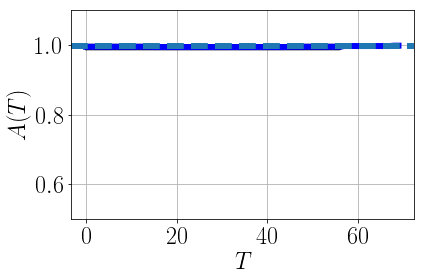

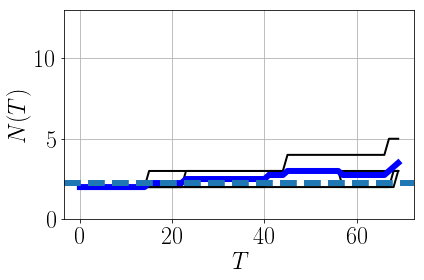

In [12]:


#These parameters are chosen to create a dataset
#Dimension of the dataset
dimension = 80

#Total number of training points
N = 1000

#Total number of test points
N_test = 700

#Intial number of points used to compute steady state, can be user entered
N_start = 30

#Number of realizations
N_reals = 40

#The realization accuracies
test_accuracys = np.zeros([N_reals,N - N_start])
number_actives = np.zeros([N_reals,N - N_start])


batcherror, batch_number_active = 0 , 0
#loop over realizations
for r in range(N_reals):

	#get the training and test set
	xvals , yvals = train_data(N,dimension)
	test_xvals , test_yvals =  test_data(N_test,dimension)


	#the intial datapoints and labels
	intial_xvals = xvals[0:N_start,:]
	intial_yvals = yvals[0:N_start]


	#Get the intial set of active datapoints, active datapoint labels, support vector values and the Lagrange multiplier
	intial_active_data_x, intial_active_data_y, intial_support_vects = EcoSVM_initialize(intial_xvals,intial_yvals)

	#Run the EcoSVM algorithm on the dataset
	active_data_x, active_data_y , support_vects, test_accuracy, number_active = Run_EcoSVM( xvals, yvals, intial_active_data_x, intial_active_data_y, intial_support_vects  )

	test_accuracys[r,:] = test_accuracy
	number_actives[r,:] = number_active

	#Get the full batch solution to compare
	batch_data_x, batch_data_y,  batch_support_vects = batchSVM( xvals,yvals )
	batch_number_active =  batch_number_active +  len(batch_data_y)

	#compute the batch b value
	bfull = b_value(batch_data_x,batch_data_y,batch_support_vects)
	#compute the batch accuracy
	batcherror = batcherror + SVM_error(test_xvals,test_yvals, batch_data_x, batch_data_y, batch_support_vects,bfull)


#averge batch error, averge number of batch support vectors
batcherror = batcherror / N_reals
batch_number_active = batch_number_active / N_reals

#make accuracy plots vs time
import os

os.environ["PATH"] += ':/usr/local/texlive/2015/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.tick_params(labelsize=16)

fontsize = 22

avg_test_accuarcy = np.zeros([N - N_start])
avg_number_active = np.zeros([N - N_start])


for i in range(N - N_start):

	avg_test_accuarcy[i] = np.average( test_accuracys[:,i]  )
	avg_number_active[i] = np.average( number_actives[:,i]  )


for r in range(N_reals):
	#Make plots of EcoSVM accuracy vs time
	plt.plot(test_accuracys[r,:], linewidth=2, color = 'k')


plt.plot(avg_test_accuarcy, linewidth=6, color = 'b')
plt.axhline(y = 1 - batcherror,linestyle='--',linewidth=6)
plt.ylim(0.5,1.1)
plt.ylabel("$A(T) $",fontsize = fontsize + 2)
plt.xlabel("$ T  $" ,fontsize=fontsize + 2)
plt.grid()
plt.tick_params(labelsize=fontsize+2)
plt.tight_layout()
plt.show()
#plt.savefig( "./graphs/linear.acc.png " )
plt.clf()


for r in range(N_reals):
	#Make plots of EcoSVM number of support vectors vs time
	plt.plot(number_actives[r,:], linewidth=2 , color = 'k')

plt.plot(avg_number_active, linewidth=6, color = 'b')
plt.ylim(0, max( np.amax(number_active) , batch_number_active )   + 10 )
plt.axhline(y = batch_number_active,linestyle='--',linewidth=6)
plt.ylabel("$N(T) $",fontsize = fontsize + 2)
plt.xlabel("$ T  $" ,fontsize=fontsize + 2)
plt.tick_params(labelsize=fontsize+2)
plt.grid()
plt.tight_layout()
plt.show()
#plt.savefig( "./graphs/linear.numb.png " )
plt.clf()

